### Imports

In [1]:
!pip install gensim
!pip install spacy
!pip install xgboost
!pip install tensorflow==2.3.1 
!pip install np_utils
!pip install Keras==2.3.*

     |████████████████████████████████| 320.4MB 42kB/s 
     |████████████████████████████████| 460kB 39.9MB/s 
     |████████████████████████████████| 20.1MB 1.6MB/s 
     |████████████████████████████████| 2.9MB 46.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 

     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57133 sha256=b1ddbc18a4bea21954b37699fc4b3f986874933e840d6353e6fbba498cae3202
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils
     |████████████████████████████████| 378kB 30.4MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [31]:
!pip install adjusttext

  Created wheel for adjusttext: filename=adjustText-0.7.3-cp37-none-any.whl size=7097 sha256=e18331ee68047d3345c82e2b8a966579d51645c20931ce3c028a7c8dc49b6b23
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjusttext


In [2]:
!git clone https://github.com/cemrifki/subclause-generator.git

!git clone -l -s git://github.com/cemrifki/subclause-generator.git cloned-repo
%cd cloned-repo

Cloning into 'subclause-generator'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 29 (delta 10), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (29/29), done.
Cloning into 'cloned-repo'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 29 (delta 10), reused 25 (delta 6), pack-reused 0
Receiving objects: 100% (29/29), 9.09 KiB | 9.09 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/cloned-repo


# Aspect Based Sentiment Analysis Using Advanced Machine Learning and Deep Learning Models





#### Preprocessing

In [3]:
from subclauses import SubclauseGenerator
import spacy
import numpy as np
import pandas as pd

### Datasets

The datasets are from SemEval Conference 2015-2016 from Aspect Based Sentiment Analysis tasks. Datasets include customer reviews of restaurants.

The datasets contain:

- `review text`
- `aspect term`
- `aspect category`
- `aspect polarity`
- `aspect span`

In [4]:
from collections import defaultdict
import xml.etree.ElementTree as ET

In [5]:
# Import parsed xml dataset
def extract_data(xml):

    tree = ET.parse(xml)
    root = tree.getroot()   
    data = defaultdict(list)

    for child in root:
        for review in child:
            for sentence in review:
                try:
                    for opinion in sentence.getchildren()[1].getchildren():
                        data[sentence.getchildren()[0].text].append((opinion.attrib["target"],opinion.attrib["polarity"]))
                except IndexError:
                    pass

    return data


In [6]:
# Import datasets
## SemEval 2016
TRAIN = extract_data("/content/ABSA-15_Restaurants_Train_Final.xml")
TEST = extract_data("/content/EN_REST_SB1_TEST.xml.gold")
DEV = extract_data("/content/ABSA15_Restaurants_Test.xml")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  del sys.path[0]


### Subclause Generation 

This module is originally proposed by Cem Rıfkı Aydın and Tunga Güngör. The module extracts subclauses from the main clause. In this part, I have matched the subclauses with actual classes 

- SA_TRAIN: Single aspect reviews

- MA_TRAIN: Multiple aspect reviews

In [7]:
def extract_for_aspect(data):
  SA_TRAIN = {"Review": [], "Aspect": [], "Sentiment": []}
  MA_TRAIN = {"Review": [], "Aspect": [], "Sentiment": []}

  mapping = {"negative": 0,"positive": 1}
  for review, opinions in data.items():
    if len(opinions) == 1: # Review contains only one aspect
      if opinions[0][1] != "neutral":
        SA_TRAIN["Review"].append(review)
        SA_TRAIN["Aspect"].append(opinions[0][0])
        SA_TRAIN["Sentiment"].append(mapping[opinions[0][1]])

    else:
      subcls = SubclauseGenerator().convert_to_subclauses(review)
      if len(subcls) > 1:
        if len(subcls) > len(opinions): # The number of the generated subclauses bigger than number of aspects
            for idx in range(len(opinions)):
              if opinions[idx][0] in subcls[idx]: # Opinions include the target word
                #print(f"{subcls[idx]}: {opinions[idx][0]}")
                if opinions[idx][1] != "neutral":
                  MA_TRAIN["Review"].append(" ".join(subcls[idx]))
                  MA_TRAIN["Aspect"].append(opinions[idx][0])
                  MA_TRAIN["Sentiment"].append(mapping[opinions[idx][1]]) 
        else:
          # Fix the other cases !!
          pass

      elif len(subcls) == len(opinions):
        for idx in range(len(opinions)):
          if opinions[idx][0] in subcls[idx]: # Opinions include the target word
            #print(f"{subcls[idx]}: {opinions[idx][0]}")
            pass
          if opinions[idx][1] != "neutral":
            MA_TRAIN["Review"].append(" ".join(subcls[idx]))
            MA_TRAIN["Aspect"].append(opinions[idx][0])
            MA_TRAIN["Sentiment"].append(mapping[opinions[idx][1]])

      else:
        if opinions[0][1] != "neutral":
          MA_TRAIN["Review"].append(" ".join(subcls[0]))
          MA_TRAIN["Aspect"].append(opinions[0][0])
          MA_TRAIN["Sentiment"].append(mapping[opinions[0][1]])
  
  return SA_TRAIN, MA_TRAIN

In [78]:
SA_TRAIN, MA_TRAIN = extract_for_aspect(TRAIN) # Use as individual datasets
SA_Train = pd.DataFrame(SA_TRAIN)
MA_Train = pd.DataFrame(MA_TRAIN)
SA_Train.describe

<bound method NDFrame.describe of                                                 Review      Aspect  Sentiment
0    Judging from previous posts this used to be a ...       place          0
1    We, there were four of us, arrived at noon - t...       staff          0
2    They never brought us complimentary noodles, i...        NULL          0
3    After all that, they complained to me about th...        NULL          0
4                                    Avoid this place!       place          0
..                                                 ...         ...        ...
720    LOVE the atmosphere - felt like I was in Paris.  atmosphere          1
721                                 I lOVE THIS PLACE!       PLACE          1
722                        Keep up the good work guys!        NULL          1
723  I have to say I have never had a disapointing ...        meal          1
724  We could have made a meal of the yummy dumplin...   dumplings          1

[725 rows x 3 columns]>

In [9]:
SA_TEST, MA_TEST = extract_for_aspect(TEST) # Use as individual datasets
SA_Test = pd.DataFrame(SA_TEST)
MA_Test = pd.DataFrame(MA_TEST)
SA_Test.describe

<bound method NDFrame.describe of                                                 Review  ... Sentiment
0                                                 Yum!  ...         1
1                            Serves really good sushi.  ...         1
2                    Green Tea creme brulee is a must!  ...         1
3               Don't leave the restaurant without it.  ...         1
4                                        No Comparison  ...         1
..                                                 ...  ...       ...
380  To start things off, our lovely server Brooke ...  ...         1
381  I had a taste of all three items on her plate,...  ...         1
382  Two rascally kids were seated near us for the ...  ...         0
383  All considered, I have to say that Ray's Boath...  ...         1
384                  Oh yeah...the view was good, too.  ...         1

[385 rows x 3 columns]>

In [10]:
SA_DEV, MA_DEV = extract_for_aspect(DEV) # Use as individual datasets
SA_Dev = pd.DataFrame(SA_DEV)
MA_Dev = pd.DataFrame(MA_DEV)
SA_Dev.describe

<bound method NDFrame.describe of                                                 Review    Aspect  Sentiment
0                                        Love Al Di La  Al Di La          1
1                  I recommend this place to everyone.     place          1
2                                          Great food.      food          1
3              One of my favorite places in Brooklyn.       NULL          1
4                 The food here was mediocre at best.       food          0
..                                                 ...       ...        ...
366  The waiter delivered our food while holding wh...    waiter          0
367  I can't believe that it was, but please put th...      NULL          0
368  The waitress came to check in on us every few ...  waitress          0
369  I couldn't ignore the fact that she reach over...      NULL          0
370  She then put the check down without asking if ...      NULL          0

[371 rows x 3 columns]>

In [76]:
!pip install prettytable

In [106]:
from prettytable import PrettyTable

original = PrettyTable(['Original Dataset', '# of Sentences'])
original.add_row(['Train', len(TRAIN)])
original.add_row(['Test', len(TEST)])
original.add_row(['Dev', len(DEV)])

print(original)

subclause = PrettyTable(['Original Dataset', 'Single Aspect', 'Multiple Aspect'])
subclause.add_row(['Train', len(SA_Train), len(MA_Train)])
subclause.add_row(['Test', len(SA_Test), len(MA_Test)])
subclause.add_row(['Dev', len(SA_Dev), len(MA_Dev)])

print(subclause)

+------------------+----------------+
| Original Dataset | # of Sentences |
+------------------+----------------+
|      Train       |      1118      |
|       Test       |      586       |
|       Dev        |      581       |
+------------------+----------------+
+------------------+---------------+-----------------+
| Original Dataset | Single Aspect | Multiple Aspect |
+------------------+---------------+-----------------+
|      Train       |      725      |       200       |
|       Test       |      385      |       100       |
|       Dev        |      371      |       115       |
+------------------+---------------+-----------------+


### Feature Extraction

In this module, training and test data are vectorized by pre-trained word2vec model . The model is trained with google news data.

- Model name: `word2vec-google-news-300`
- Vector length: `300` 

In [96]:
from gensim import downloader

In [97]:
word2vec = downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [98]:
model = word2vec.wv
nlp = spacy.load("en_core_web_sm")

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [99]:
def word2vec_feature_extraction(text,model,tokenizer):
    vector = np.zeros(300)
    for token in tokenizer(text):
        word = token.text.lower()
        if word in model.vocab:
            vector += model[word]
    return vector

In [100]:
SA_X_train = []
SA_y_train = [sent for sent in SA_Train["Sentiment"]]

for review in SA_Train["Review"]:
    SA_X_train.append(word2vec_feature_extraction(review,model,nlp))
    
SA_X_test = []
SA_y_test = [sent for sent in SA_Test["Sentiment"]]

for review in SA_Test["Review"]:
    SA_X_test.append(word2vec_feature_extraction(review,model,nlp))

In [101]:
MA_X_train = []
MA_y_train = [sent for sent in MA_Train["Sentiment"]]

for review in MA_Train["Review"]:
    MA_X_train.append(word2vec_feature_extraction(review,model,nlp))
    
MA_X_test = []
MA_y_test = [sent for sent in MA_Test["Sentiment"]]

for review in MA_Test["Review"]:
    MA_X_test.append(word2vec_feature_extraction(review,model,nlp))

In [102]:
SA_X_dev = []
SA_X_dev = [sent for sent in SA_Dev["Sentiment"]]

for review in SA_Train["Review"]:
    SA_X_dev.append(word2vec_feature_extraction(review,model,nlp))

MA_X_dev = []
MA_y_dev = [sent for sent in MA_Dev["Sentiment"]]

for review in MA_Train["Review"]:
    MA_X_dev.append(word2vec_feature_extraction(review,model,nlp))

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(np.array(MA_X_train))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0
0
10
10
20
20
30
30
40
40
50
50
60
60
70
70
80
80
90
90
100
100
110
110
120
120
130
130
140
140
150
150
160
160
170
170
180
180
190
190
200
200
210
210
220
220
230
230
240
240
250
250
260
260
270
270
280
280
290
290
300
300
310
310
320
320
330
330
340
340
350
350
360
360
370
370
380
380
390
390
400
400
410
410
420
420
430
430
440
440
450
450
460
460
470
470
480
480
490
490
500
500
510
510
520
520
530
530
540
540
550
550
560
560
570
570
580
580
590
590
600
600
610
610
620
620
630
630
640
640
650
650
660
660
670
670
680
680
690
690
700
700
710
710
720
720


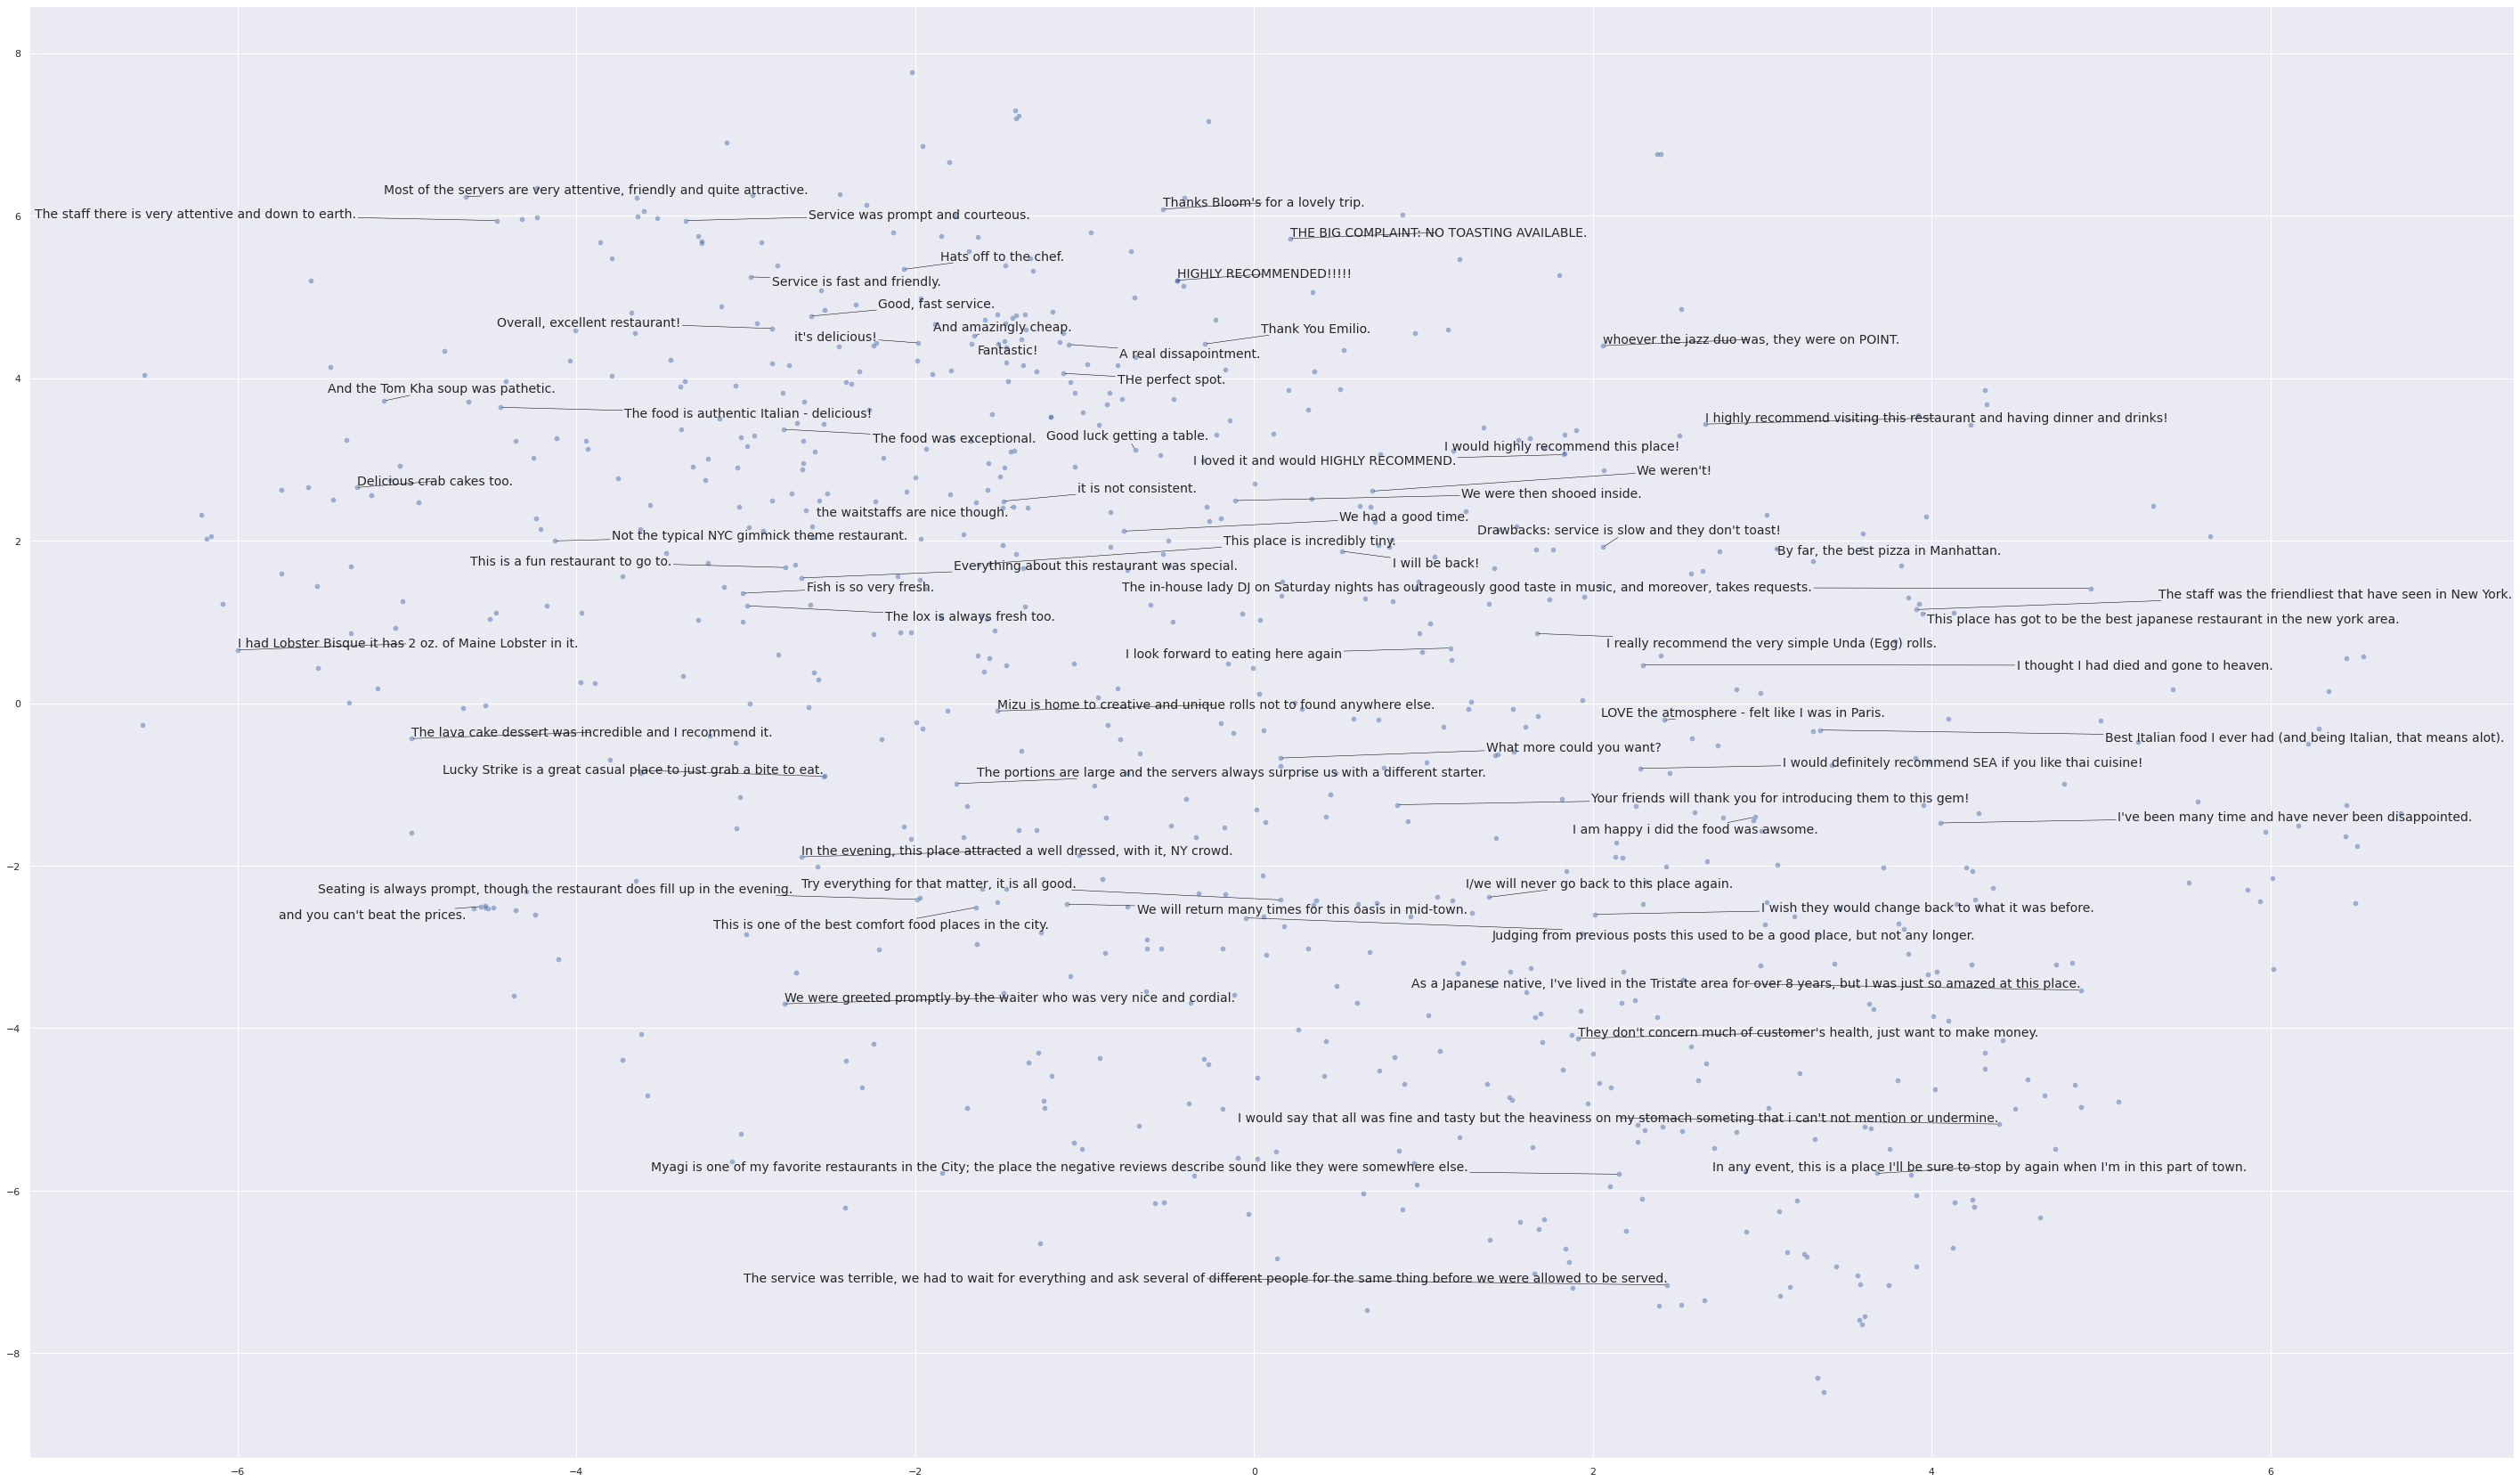

In [38]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (50, 30))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, len(MA_Train["Review"]), 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], MA_Train["Review"][word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Aspect Polarity Classification (APC)

This task involves prediction of sentiment for given aspect term. Since the both data is generated by subclause extraction for each aspect term, there is a unique instance of review

There are 3 classifiers compared in this section:

- Support Vector Machine Classifier
- XGBoost Classifier
- Fine-Tuned BERT Base Classifier

### Support Vector Machine Classifier

In this classifier, multiple kernels have been implemented:

- Linear Kernel
- Polynomial Kernel
- RBF Kernel
- Sigmoid Kernel

TODO:

- Add cross validation 

In [39]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

#### Single Aspect

In [40]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(np.array(SA_X_train), np.array(SA_y_train))
linear_pred = linear.predict(SA_X_test)
print("Classification Report of Linear Kernel: \n", classification_report(SA_y_test,linear_pred))
print("Confusion Report of Linear Kernel: \n", confusion_matrix(SA_y_test,linear_pred))

Classification Report of Linear Kernel: 
               precision    recall  f1-score   support

           0       0.61      0.69      0.65       104
           1       0.88      0.83      0.86       281

    accuracy                           0.79       385
   macro avg       0.74      0.76      0.75       385
weighted avg       0.81      0.79      0.80       385

Confusion Report of Linear Kernel: 
 [[ 72  32]
 [ 47 234]]


In [41]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(np.array(SA_X_train), np.array(SA_y_train))
rbf_pred = rbf.predict(SA_X_test)
print("Classification Report of RBF Kernel: \n",classification_report(SA_y_test,rbf_pred))
print("Confusion Report of RBF Kernel: \n", confusion_matrix(SA_y_test,rbf_pred))

Classification Report of RBF Kernel: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.73      1.00      0.84       281

    accuracy                           0.73       385
   macro avg       0.36      0.50      0.42       385
weighted avg       0.53      0.73      0.62       385

Confusion Report of Linear Kernel: 
 [[  0 104]
 [  0 281]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(np.array(SA_X_train), np.array(SA_y_train))
poly_pred = poly.predict(SA_X_test)
print("Classification Report of Polynomial Kernel: \n",classification_report(SA_y_test,poly_pred))
print("Confusion Matrix of Polynomial Kernel: \n",confusion_matrix(SA_y_test,poly_pred))

Classification Report of Polynomial Kernel: 
               precision    recall  f1-score   support

           0       0.73      0.35      0.47       104
           1       0.80      0.95      0.87       281

    accuracy                           0.79       385
   macro avg       0.77      0.65      0.67       385
weighted avg       0.78      0.79      0.76       385



In [43]:
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(np.array(SA_X_train), np.array(SA_y_train))
sig_pred = sig.predict(SA_X_test)
print("Classification Report of Sigmoid Kernel: \n",classification_report(SA_y_test,sig_pred))

Classification Report of Sigmoid Kernel: 
               precision    recall  f1-score   support

           0       0.41      0.25      0.31       104
           1       0.76      0.87      0.81       281

    accuracy                           0.70       385
   macro avg       0.59      0.56      0.56       385
weighted avg       0.66      0.70      0.67       385



#### Multiple Aspects

In [44]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(np.array(MA_X_train), np.array(MA_y_train))
linear_pred = linear.predict(MA_X_test)
print("Classification Report of Linear Kernel: \n", classification_report(MA_y_test,linear_pred))

Classification Report of Linear Kernel: 
               precision    recall  f1-score   support

           0       0.46      0.71      0.56        17
           1       0.93      0.83      0.88        83

    accuracy                           0.81       100
   macro avg       0.70      0.77      0.72       100
weighted avg       0.85      0.81      0.82       100



In [45]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(np.array(MA_X_train), np.array(MA_y_train))
rbf_pred = rbf.predict(MA_X_test)
print("Classification Report of RBF Kernel: \n",classification_report(MA_y_test,rbf_pred))

Classification Report of RBF Kernel: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.83      1.00      0.91        83

    accuracy                           0.83       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.69      0.83      0.75       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(np.array(MA_X_train), np.array(MA_y_train))
poly_pred = poly.predict(MA_X_test)
print("Classification Report of Polynomial Kernel: \n",classification_report(MA_y_test,poly_pred))

Classification Report of Polynomial Kernel: 
               precision    recall  f1-score   support

           0       0.55      0.35      0.43        17
           1       0.88      0.94      0.91        83

    accuracy                           0.84       100
   macro avg       0.71      0.65      0.67       100
weighted avg       0.82      0.84      0.83       100



In [47]:
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(np.array(MA_X_train), np.array(MA_y_train))
sig_pred = sig.predict(MA_X_test)
print("Classification Report of Sigmoid Kernel: \n",classification_report(MA_y_test,sig_pred))

Classification Report of Sigmoid Kernel: 
               precision    recall  f1-score   support

           0       0.32      0.35      0.33        17
           1       0.86      0.84      0.85        83

    accuracy                           0.76       100
   macro avg       0.59      0.60      0.59       100
weighted avg       0.77      0.76      0.77       100



### XGBoost Classifier 

XGBoost is a popular algorithm commonly used in the industry. Although it is not generally used in the academic research, it is used in this study.

The parameters of this algorithm is tuned by Grid Search module from `sklearn`


In [109]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [104]:
xgb_cl = xgb.XGBClassifier()

In [105]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


clf = GridSearchCV(xgb_cl, params, n_jobs=4, 
                   cv=StratifiedKFold().split(np.array(SA_X_train),SA_y_train), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(np.array(SA_X_train),SA_y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 15.5min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 2025 out of 2025 | elapsed: 23.8min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fc4c838abd0>,
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5]

In [107]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

#### Single Aspect

In [110]:
print("Classification Report of XGBoost with Softplus: \n", classification_report(SA_y_test,clf.predict(SA_X_test)))
print("Confusion Matrix of XGBoost with Softplus: \n", confusion_matrix(SA_y_test,clf.predict(SA_X_test)))

Classification Report of XGBoost with Softplus: 
               precision    recall  f1-score   support

           0       0.70      0.57      0.63       104
           1       0.85      0.91      0.88       281

    accuracy                           0.82       385
   macro avg       0.78      0.74      0.75       385
weighted avg       0.81      0.82      0.81       385

Confusion Matrix of XGBoost with Softplus: 
 [[ 59  45]
 [ 25 256]]


#### Multiple Aspect

In [54]:
print("Classification Report of XGBoost with Softplus: \n", classification_report(MA_y_test,clf.predict(MA_X_test)))
print("Classification Report of XGBoost with Softplus: \n", confusion_matrix(MA_y_test,clf.predict(MA_X_test)))

Classification Report of XGBoost with Softplus: 
               precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.92      0.94      0.93        83

    accuracy                           0.88       100
   macro avg       0.79      0.76      0.78       100
weighted avg       0.87      0.88      0.88       100

Classification Report of XGBoost with Softplus: 
 [[10  7]
 [ 5 78]]


### **B**idirectional **E**ncoder **R**epresentations from **T**ransformers (BERT)

BERT is the state-of-the-art pretrained language model proposed 2018 by Google. This model utilizes *transformer* architecture to encode sequential data. This model is fine-tuned for various tasks such as language generation, text classification and sequence encoding. 

In this study, I will be using `bert-base-uncased` model which is mostly used for classification tasks.

I will be using parameters introduced in the original paper:



Also there is a final softmax layer for classification


In [11]:
!pip install transformers

     |████████████████████████████████| 2.5MB 26.4MB/s 
     |████████████████████████████████| 3.3MB 41.9MB/s 
     |████████████████████████████████| 901kB 36.5MB/s 


In [12]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import tensorflow as tf
import pandas as pd

In [14]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [15]:
def convert_data_to_examples(train, test): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x["Review"], 
                                                          text_b = None,
                                                          label = x["Sentiment"]), axis = 1)

  dev_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x["Review"], 
                                                          text_b = None,
                                                          label = x["Sentiment"]), axis = 1)
  
  return train_InputExamples, dev_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    # Holds converter features
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True, 
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(gen,
              ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
              (
                  {
                      "input_ids": tf.TensorShape([None]),
                      "attention_mask": tf.TensorShape([None]),
                      "token_type_ids": tf.TensorShape([None]),
                  },
                  tf.TensorShape([]),
              ),
            )

In [16]:
## Train and validation
train_InputExamples, dev_InputExamples = convert_data_to_examples(SA_Train, SA_Dev)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

dev_data = convert_examples_to_tf_dataset(list(dev_InputExamples), tokenizer)
dev_data = dev_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=dev_data)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [83]:
def predict(pred_sentences)

  tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()

  return [label[i] for i in range(len(pred_sentences))]

In [53]:
print(classification_report(list(SA_Test["Sentiment"]),predict(SA_Test["Review"])))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       104
           1       0.94      0.92      0.93       281

    accuracy                           0.90       385
   macro avg       0.87      0.87      0.87       385
weighted avg       0.90      0.90      0.90       385



In [85]:
print(classification_report(list(MA_Test["Sentiment"]),predict(MA_Test["Review"])))

              precision    recall  f1-score   support

           0       0.60      0.88      0.71        17
           1       0.97      0.88      0.92        83

    accuracy                           0.88       100
   macro avg       0.79      0.88      0.82       100
weighted avg       0.91      0.88      0.89       100



### BERT Explained with SHAP

In [21]:
!pip install shap

     |████████████████████████████████| 358kB 29.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=9e67608eeb969bab30956653476a19a2b826424a7e1782e53c8478d56c5afe09
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [54]:
import shap
import torch
import scipy as sp

shap.initjs()

# define a prediction function
def f(x):

  tf_batch = tokenizer(list(x), max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  labels = [0,1]
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()

  return label

# build an explainer using a token masker
BERT_explainer = shap.Explainer(f, tokenizer)

BERT_shap_values = BERT_explainer(SA_Test["Review"][:50], fixed_context=1)

<class 'pandas.core.series.Series'>


Partition explainer:  46%|████▌     | 23/50 [00:49<01:12,  2.70s/it]

Partition explainer:  48%|████▊     | 24/50 [00:57<01:50,  4.23s/it]

Partition explainer:  84%|████████▍ | 42/50 [01:36<00:20,  2.58s/it]

Partition explainer:  86%|████████▌ | 43/50 [01:44<00:29,  4.17s/it]

Partition explainer:  92%|█████████▏| 46/50 [01:49<00:10,  2.60s/it]

Partition explainer:  94%|█████████▍| 47/50 [01:57<00:12,  4.15s/it]

Partition explainer: 51it [02:07,  2.49s/it]


In [56]:
shap.plots.text(shap_values[5])

In [62]:
shap.plots.text(shap_values[9])

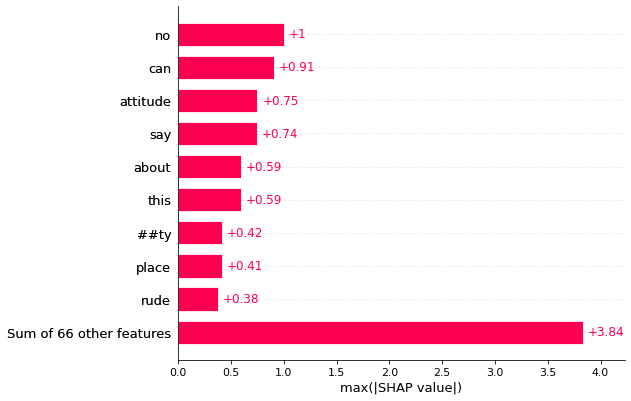

In [63]:
shap.plots.bar(shap_values.abs.max(0))

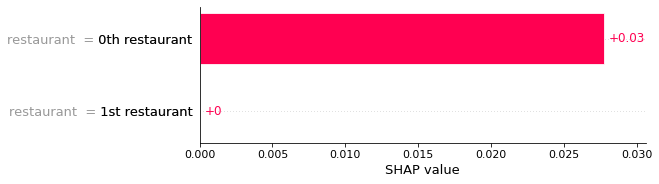

In [73]:
shap.plots.bar(shap_values[:,"restaurant"])

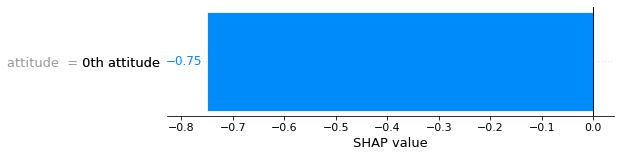

In [74]:
shap.plots.bar(shap_values[:,"attitude"])